1. Из ноутбуков по практике "Рекуррентные и одномерные сверточные нейронные сети" выберите лучшую сеть, либо создайте свою.
2. Запустите раздел "Подготовка"
3. Подготовьте датасет с параметрами `VOCAB_SIZE=20'000`, `WIN_SIZE=1000`, `WIN_HOP=100`, как в ноутбуке занятия, и обучите выбранную сеть. Параметры обучения можно взять из практического занятия. Для  всех обучаемых сетей в данной работе они должны быть одни и теже.
4. Поменяйте размер словаря tokenaizera (`VOCAB_SIZE`) на `5000`, `10000`, `40000`.  Пересоздайте датасеты, при этом оставьте `WIN_SIZE=1000`, `WIN_HOP=100`.
Обучите выбранную нейронку на этих датасетах.  Сделайте выводы об  изменении  точности распознавания авторов текстов. Результаты сведите в таблицу
5. Поменяйте длину отрезка текста и шаг окна разбиения текста на векторы  (`WIN_SIZE`, `WIN_HOP`) используя значения (`500`,`50`) и (`2000`,`200`). Пересоздайте датасеты, при этом оставьте `VOCAB_SIZE=20000`. Обучите выбранную нейронку на этих датасетах. Сделайте выводы об  изменении точности распознавания авторов текстов.

Результаты всей работы сведите в таблицу.

## Подготовка

In [ ]:
# Работа с массивами данных
import numpy as np

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

%matplotlib inline

In [ ]:
# Загрузим датасет из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l7/writers.zip', None, quiet=True)

'writers.zip'

In [ ]:
# Распакуем архив в папку writers
!unzip -o writers.zip -d writers/


Archive:  writers.zip
  inflating: writers/(Клиффорд_Саймак) Обучающая_5 вместе.txt  
  inflating: writers/(Клиффорд_Саймак) Тестовая_2 вместе.txt  
  inflating: writers/(Макс Фрай) Обучающая_5 вместе.txt  
  inflating: writers/(Макс Фрай) Тестовая_2 вместе.txt  
  inflating: writers/(О. Генри) Обучающая_50 вместе.txt  
  inflating: writers/(О. Генри) Тестовая_20 вместе.txt  
  inflating: writers/(Рэй Брэдберри) Обучающая_22 вместе.txt  
  inflating: writers/(Рэй Брэдберри) Тестовая_8 вместе.txt  
  inflating: writers/(Стругацкие) Обучающая_5 вместе.txt  
  inflating: writers/(Стругацкие) Тестовая_2 вместе.txt  
  inflating: writers/(Булгаков) Обучающая_5 вместе.txt  
  inflating: writers/(Булгаков) Тестовая_2 вместе.txt  


In [ ]:
# Настройка констант для загрузки данных
FILE_DIR  = 'writers'                     # Папка с текстовыми файлами
SIG_TRAIN = 'обучающая'                   # Признак обучающей выборки в имени файла
SIG_TEST  = 'тестовая'                    # Признак тестовой выборки в имени файла

In [ ]:
# Подготовим пустые списки

CLASS_LIST = []  # Список классов
text_train = []  # Список для оучающей выборки
text_test = []   # Список для тестовой выборки

# Получим списка файлов в папке
file_list = os.listdir(FILE_DIR)

for file_name in file_list:
    # Выделяем имя класса и типа выборки из имени файла
    m = re.match('\((.+)\) (\S+)_', file_name)
    # Если выделение получилось, то файл обрабатываем
    if m:

        # Получим имя класса
        class_name = m[1]

        # Получим имя выборки
        subset_name = m[2].lower()

        # Проверим тип выборки
        is_train = SIG_TRAIN in subset_name
        is_test = SIG_TEST in subset_name

        # Если тип выборки обучающая либо тестовая - файл обрабатываем
        if is_train or is_test:

            # Добавляем новый класс, если его еще нет в списке
            if class_name not in CLASS_LIST:
                print(f'Добавление класса "{class_name}"')
                CLASS_LIST.append(class_name)

                # Инициализируем соответствующих классу строки текста
                text_train.append('')
                text_test.append('')

            # Найдем индекс класса для добавления содержимого файла в выборку
            cls = CLASS_LIST.index(class_name)
            print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}", {subset_name} выборка.')

            # Откроем файл на чтение
            with open(f'{FILE_DIR}/{file_name}', 'r') as f:

                # Загрузим содержимого файла в строку
                text = f.read()
            # Определим выборку, куда будет добавлено содержимое
            subset = text_train if is_train else text_test

            # Добавим текста к соответствующей выборке класса. Концы строк заменяются на пробел
            subset[cls] += ' ' + text.replace('\n', ' ')

Добавление класса "Рэй Брэдберри"
Добавление файла "(Рэй Брэдберри) Тестовая_8 вместе.txt" в класс "Рэй Брэдберри", тестовая выборка.
Добавление класса "Макс Фрай"
Добавление файла "(Макс Фрай) Обучающая_5 вместе.txt" в класс "Макс Фрай", обучающая выборка.
Добавление файла "(Макс Фрай) Тестовая_2 вместе.txt" в класс "Макс Фрай", тестовая выборка.
Добавление файла "(Рэй Брэдберри) Обучающая_22 вместе.txt" в класс "Рэй Брэдберри", обучающая выборка.
Добавление класса "О. Генри"
Добавление файла "(О. Генри) Тестовая_20 вместе.txt" в класс "О. Генри", тестовая выборка.
Добавление класса "Булгаков"
Добавление файла "(Булгаков) Тестовая_2 вместе.txt" в класс "Булгаков", тестовая выборка.
Добавление файла "(О. Генри) Обучающая_50 вместе.txt" в класс "О. Генри", обучающая выборка.
Добавление класса "Стругацкие"
Добавление файла "(Стругацкие) Обучающая_5 вместе.txt" в класс "Стругацкие", обучающая выборка.
Добавление файла "(Стругацкие) Тестовая_2 вместе.txt" в класс "Стругацкие", тестовая выб

In [ ]:
# Определим количество классов
CLASS_COUNT = len(CLASS_LIST)

In [ ]:
# Выведем прочитанные классы текстов
print(CLASS_LIST)

['Рэй Брэдберри', 'Макс Фрай', 'О. Генри', 'Булгаков', 'Стругацкие', 'Клиффорд_Саймак']


In [ ]:
# Посчитаем количество текстов в обучающей выборке
print(len(text_train))

6


In [ ]:
# Проверим загрузки: выведем начальные отрывки из каждого класса

for cls in range(CLASS_COUNT):                   # Запустим цикл по числу классов
    print(f'Класс: {CLASS_LIST[cls]}')           # Выведем имя класса
    print(f'  train: {text_train[cls][:200]}')   # Выведем фрагмент обучающей выборки
    print(f'  test : {text_test[cls][:200]}')    # Выведем фрагмент тестовой выборки
    print()

Класс: Рэй Брэдберри
  train:  ﻿451° по Фаренгейту   ДОНУ КОНГДОНУ С БЛАГОДАРНОСТЬЮ   Если тебе дадут линованную бумагу, пиши поперёк.  Хуан Рамон Хименес   Часть 1  ОЧАГ И САЛАМАНДРА   Жечь было наслаждением. Какое-то особое насл
  test :  ﻿Марсианские хроники   МОЕЙ ЖЕНЕ МАРГАРЕТ С ИСКРЕННЕЙ ЛЮБОВЬЮ   «Великое дело – способность удивляться, – сказал философ. – Космические полеты снова сделали всех нас детьми».   Январь 1999  Ракетное 

Класс: Макс Фрай
  train:  ﻿Власть несбывшегося   – С тех пор как меня угораздило побывать в этой грешной Черхавле, мне ежедневно снится какая-то дичь! – сердито сказал я Джуффину. – Сглазили они меня, что ли? А собственно, по
  test :  ﻿Слишком много кошмаров    Когда балансируешь над пропастью на узкой, скользкой от крови доске, ответ на закономерный вопрос: «Как меня сюда занесло?» – вряд ли принесёт практическую пользу. Зато пои

Класс: О. Генри
  train:  «Лиса-на-рассвете»   Коралио нежился в полуденном зное, как томная красавица в сурово хранимом

In [ ]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with

class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

## Решение

###Преобразование текстовых данных в числовые и векторные представления для обучения нейросети

In [ ]:
VOCAB_SIZE = 20000
WIN_SIZE   = 1000
WIN_HOP    = 100

**Токенизация и преобразование в последовательности**

In [ ]:
with timex():
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
    tokenizer.fit_on_texts(text_train)
    items = list(tokenizer.word_index.items())

Время обработки: 2.36 с


In [ ]:
with timex():
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    print("Фрагмент обучающего текста:")
    print("В виде оригинального текста:              ", text_train[1][:101])
    print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:                ﻿Власть несбывшегося   – С тех пор как меня угораздило побывать в этой грешной Черхавле, мне ежеднев
Он же в виде последовательности индексов:  [1504, 1, 8, 282, 236, 11, 24, 10032, 6042, 3, 144, 7831, 1, 21, 3650, 12832, 238, 12, 19870, 1300]
Время обработки: 2.68 с


In [ ]:
def split_sequence(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

def vectorize_sequence(seq_list, win_size, hop):
    class_count = len(seq_list)
    x, y = [], []

    for cls in range(class_count):
        vectors = split_sequence(seq_list[cls], win_size, hop)
        x += vectors
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    return np.array(x), np.array(y)

In [ ]:
with timex():
    x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
    x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)

(17640, 1000) (17640, 6)
(6686, 1000) (6686, 6)
Время обработки: 2.07 с


## **Сервисные функции**

In [ ]:
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Вывод схемы модели
    display(plot_model(model, dpi=60, show_shapes=True))

    # Обучение модели с заданными параметрами
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


# Функция вывода результатов оценки модели на заданных данных
def eval_model(model, x, y_true,
               class_labels=[],
               cm_round=3,
               title='',
               figsize=(10, 10)):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))


# Совместная функция обучения и оценки модели нейронной сети
def compile_train_eval_model(model,
                             x_train,
                             y_train,
                             x_test,
                             y_test,
                             class_labels=CLASS_LIST,
                             title='',
                             optimizer='adam',
                             epochs=50,
                             batch_size=128,
                             graph_size=(20, 5),
                             cm_size=(10, 10)):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model,
                        x_train, y_train,
                        x_test, y_test,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, x_test, y_test,
               class_labels=class_labels,
               title=title,
               figsize=cm_size)

## **Создание модели и обучение**

In [ ]:
model_LSTM_6 = Sequential()
model_LSTM_6.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_6.add(SpatialDropout1D(0.4))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_6.add(GRU(16, reset_after=True))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Dense(200, activation='relu'))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
model_LSTM_6.add(Dense(CLASS_COUNT, activation='softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          1000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 50)         0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 1000, 50)         200       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 16)         3776      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 16)         1600      
 nal)                                                   

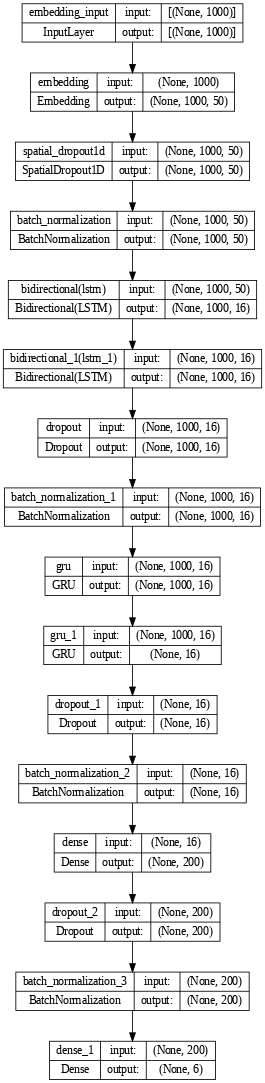

Epoch 1/100
35/35 [==============================] - 33s 438ms/step - loss: 2.0460 - accuracy: 0.2232 - val_loss: 1.7381 - val_accuracy: 0.2929
Epoch 2/100
35/35 [==============================] - 12s 334ms/step - loss: 1.7952 - accuracy: 0.3088 - val_loss: 1.7421 - val_accuracy: 0.2929
Epoch 3/100
35/35 [==============================] - 10s 300ms/step - loss: 1.5195 - accuracy: 0.4273 - val_loss: 1.7779 - val_accuracy: 0.2929
Epoch 4/100
35/35 [==============================] - 11s 331ms/step - loss: 1.1722 - accuracy: 0.5571 - val_loss: 1.7060 - val_accuracy: 0.2765
Epoch 5/100
35/35 [==============================] - 10s 278ms/step - loss: 0.8697 - accuracy: 0.6699 - val_loss: 1.6701 - val_accuracy: 0.3768
Epoch 6/100
35/35 [==============================] - 9s 262ms/step - loss: 0.6760 - accuracy: 0.7516 - val_loss: 2.2616 - val_accuracy: 0.1925
Epoch 7/100
35/35 [==============================] - 10s 276ms/step - loss: 0.5736 - accuracy: 0.7939 - val_loss: 2.0939 - val_accuracy: 

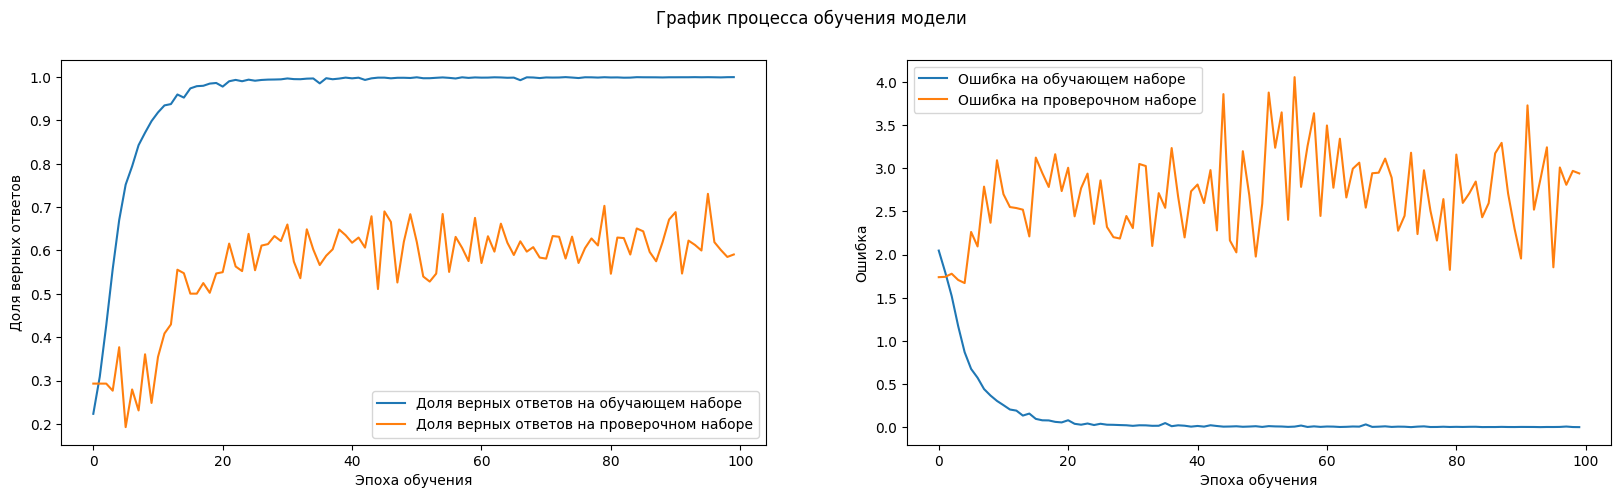

209/209 [==============================] - 15s 61ms/step


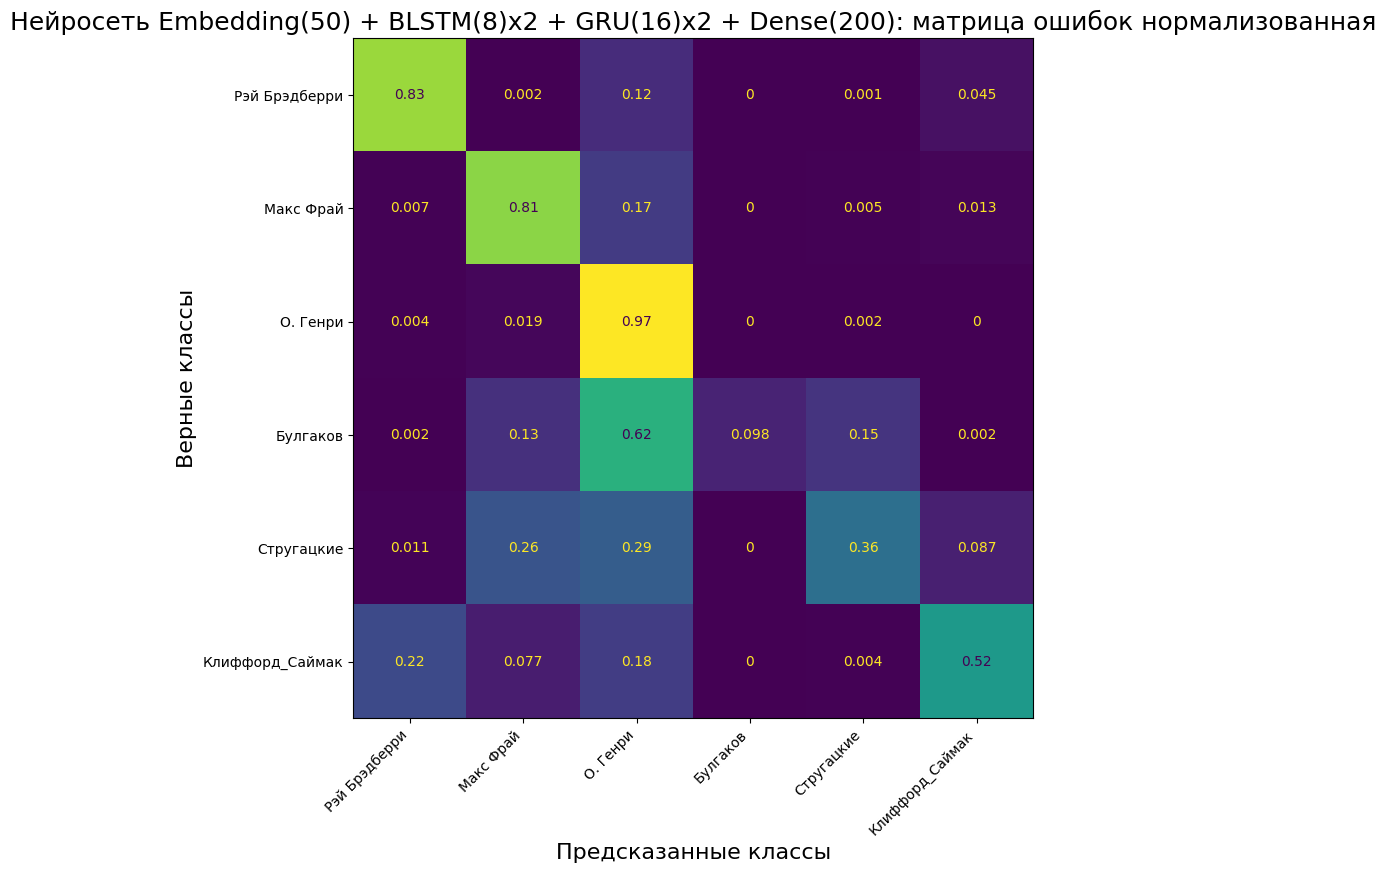

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Рэй Брэдберри         83% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Макс Фрай             80% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              98% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Булгаков              62% сеть отнесла к классу О. Генри             - НЕВЕРНО :-(
Класс: Стругацкие            36% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Клиффорд_Саймак       52% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  60%


In [ ]:
compile_train_eval_model(model_LSTM_6,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

In [ ]:
def param(vocab_size, win_size, win_hop, text_train_):
  VOCAB_SIZE = vocab_size
  WIN_SIZE   = win_size
  WIN_HOP    = win_hop
  text_train = text_train_

  tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
  tokenizer.fit_on_texts(text_train)
  items = list(tokenizer.word_index.items())

  seq_train = tokenizer.texts_to_sequences(text_train)
  seq_test = tokenizer.texts_to_sequences(text_test)

  x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
  x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

  return x_train, y_train, x_test, y_test

**VOCAB_SIZE = 5000, WIN_SIZE = 1000, WIN_HOP = 100**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          1000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 50)         0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 1000, 50)         200       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 16)         3776      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 16)         1600      
 nal)                                                   

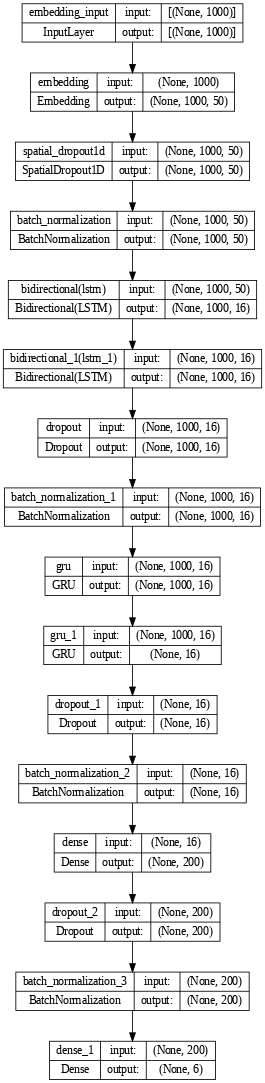

Epoch 1/100
35/35 [==============================] - 24s 344ms/step - loss: 0.0484 - accuracy: 0.9899 - val_loss: 2.4081 - val_accuracy: 0.5805
Epoch 2/100
35/35 [==============================] - 9s 259ms/step - loss: 0.0238 - accuracy: 0.9952 - val_loss: 2.4617 - val_accuracy: 0.5808
Epoch 3/100
35/35 [==============================] - 8s 229ms/step - loss: 0.0258 - accuracy: 0.9951 - val_loss: 2.2893 - val_accuracy: 0.6291
Epoch 4/100
35/35 [==============================] - 8s 236ms/step - loss: 0.0105 - accuracy: 0.9976 - val_loss: 2.0408 - val_accuracy: 0.6635
Epoch 5/100
35/35 [==============================] - 8s 240ms/step - loss: 0.0152 - accuracy: 0.9968 - val_loss: 3.4140 - val_accuracy: 0.5248
Epoch 6/100
35/35 [==============================] - 8s 238ms/step - loss: 0.0139 - accuracy: 0.9965 - val_loss: 4.0039 - val_accuracy: 0.4704
Epoch 7/100
35/35 [==============================] - 9s 247ms/step - loss: 0.0136 - accuracy: 0.9967 - val_loss: 2.2063 - val_accuracy: 0.627

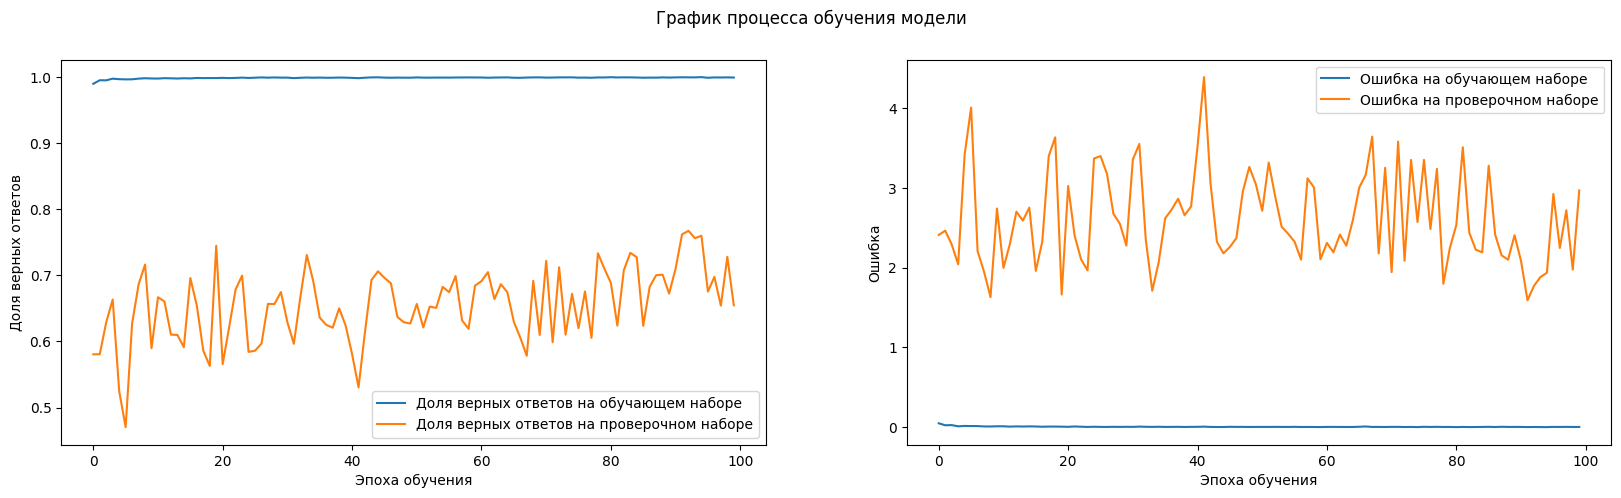

209/209 [==============================] - 14s 61ms/step


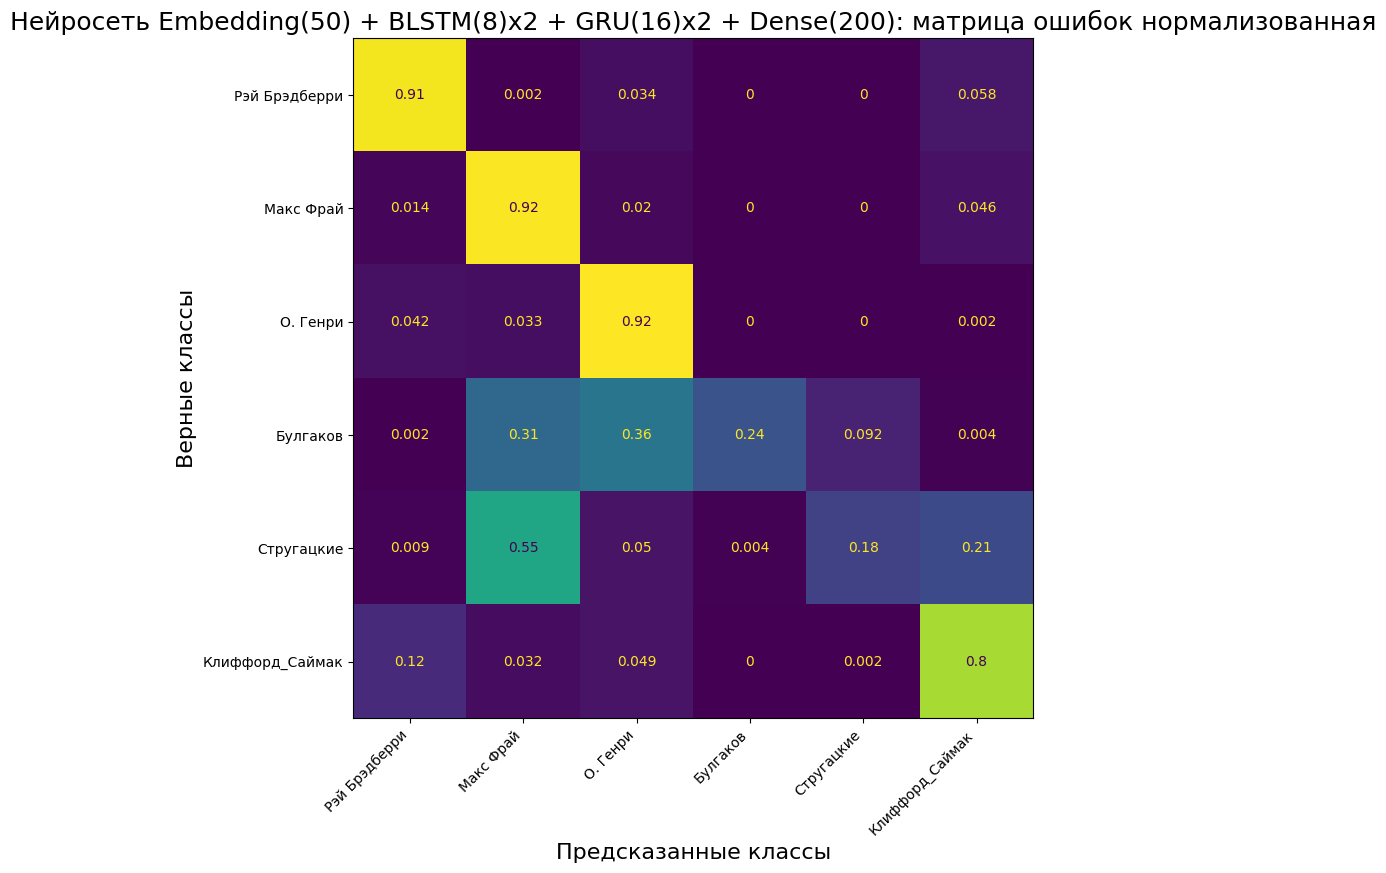

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Рэй Брэдберри         91% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Макс Фрай             92% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              92% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Булгаков              36% сеть отнесла к классу О. Генри             - НЕВЕРНО :-(
Класс: Стругацкие            55% сеть отнесла к классу Макс Фрай            - НЕВЕРНО :-(
Класс: Клиффорд_Саймак       80% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  66%


In [ ]:
x_train, y_train, x_test, y_test = param(5000, 1000, 100, text_train)

compile_train_eval_model(model_LSTM_6,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

**VOCAB_SIZE = 10000, WIN_SIZE = 1000, WIN_HOP = 100**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          1000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 50)         0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 1000, 50)         200       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 16)         3776      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 16)         1600      
 nal)                                                   

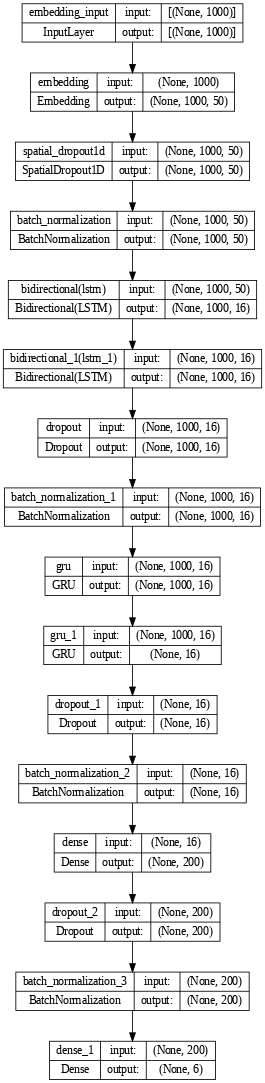

Epoch 1/100
35/35 [==============================] - 23s 366ms/step - loss: 8.6400e-04 - accuracy: 0.9998 - val_loss: 2.1875 - val_accuracy: 0.7499
Epoch 2/100
35/35 [==============================] - 10s 274ms/step - loss: 4.8799e-04 - accuracy: 0.9999 - val_loss: 2.8551 - val_accuracy: 0.6722
Epoch 3/100
35/35 [==============================] - 9s 268ms/step - loss: 7.5518e-04 - accuracy: 0.9998 - val_loss: 2.2482 - val_accuracy: 0.7345
Epoch 4/100
35/35 [==============================] - 9s 247ms/step - loss: 9.8201e-04 - accuracy: 0.9997 - val_loss: 2.2105 - val_accuracy: 0.7333
Epoch 5/100
35/35 [==============================] - 9s 254ms/step - loss: 7.1631e-04 - accuracy: 0.9996 - val_loss: 1.8850 - val_accuracy: 0.7601
Epoch 6/100
35/35 [==============================] - 9s 252ms/step - loss: 3.1851e-04 - accuracy: 0.9999 - val_loss: 1.8356 - val_accuracy: 0.7553
Epoch 7/100
35/35 [==============================] - 9s 247ms/step - loss: 4.7793e-04 - accuracy: 0.9999 - val_loss:

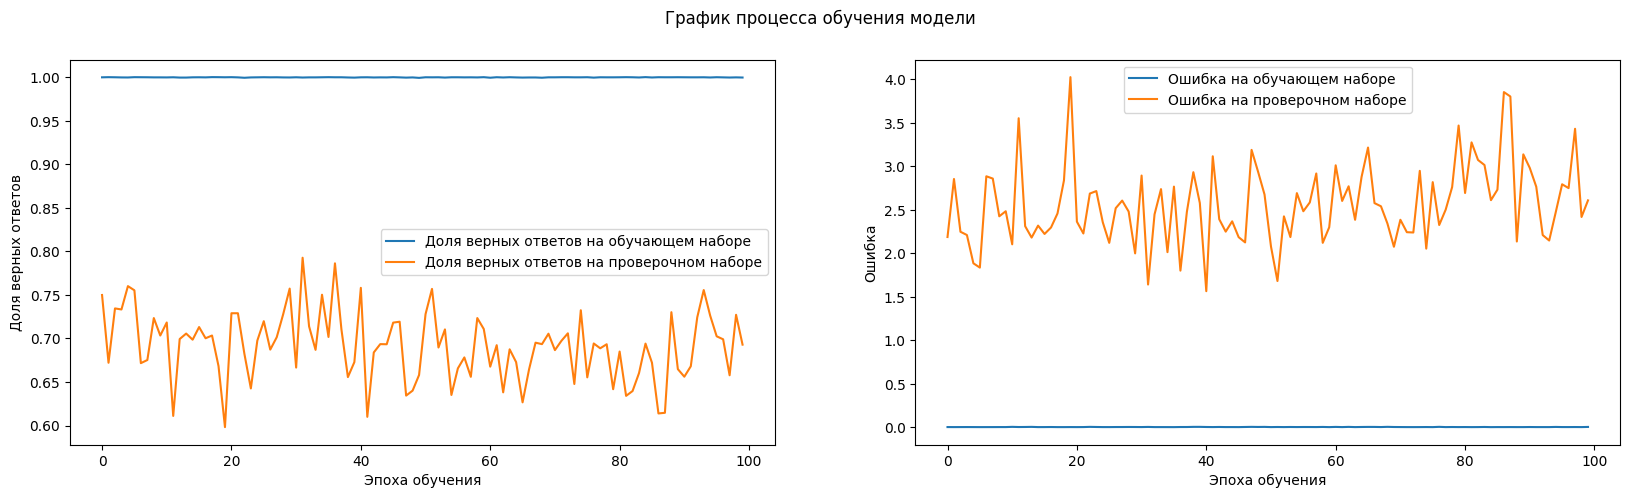

209/209 [==============================] - 15s 62ms/step


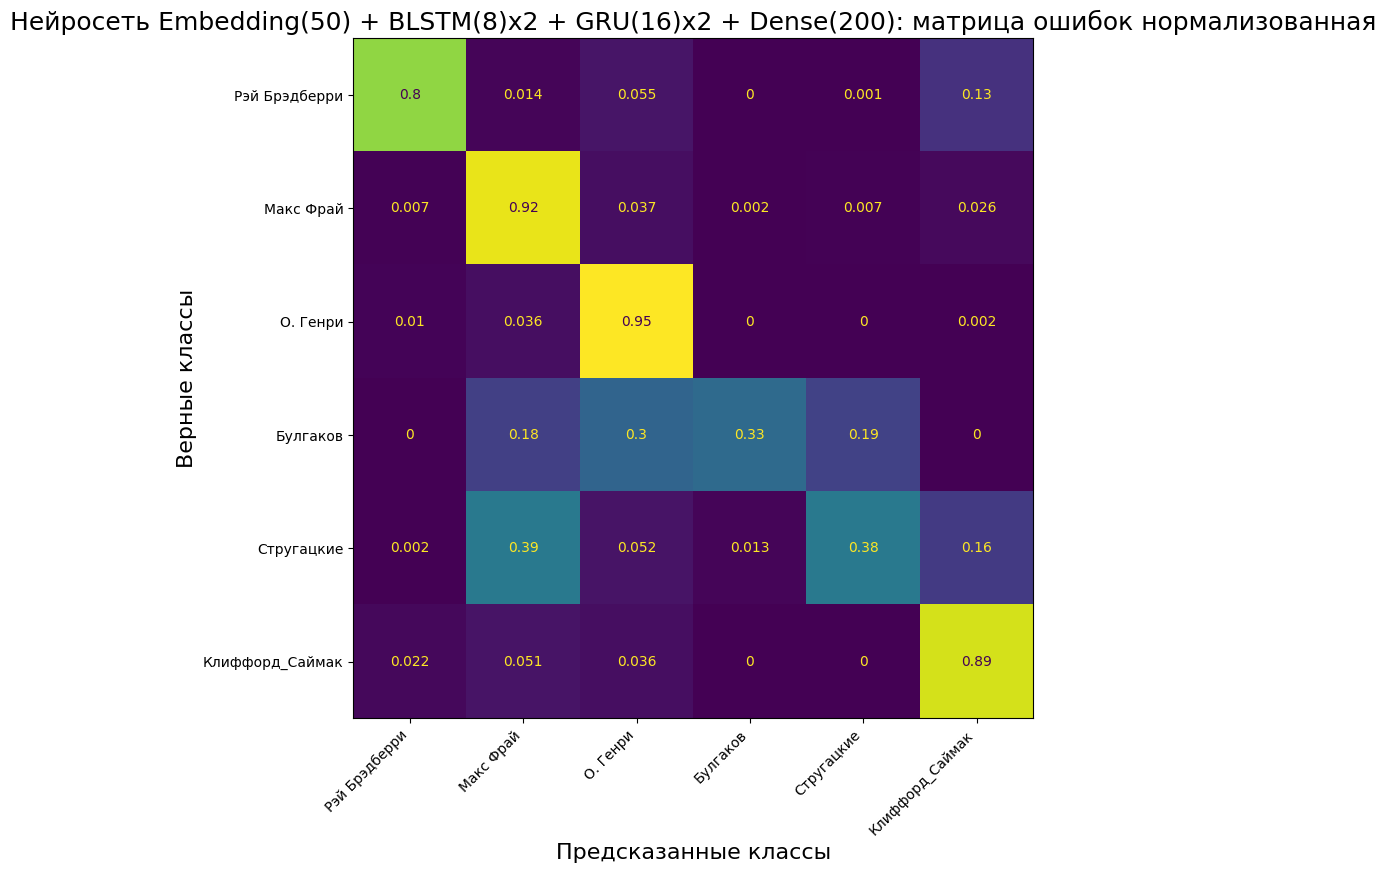

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Рэй Брэдберри         80% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Макс Фрай             92% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              95% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Булгаков              33% сеть отнесла к классу Булгаков             - ВЕРНО :-)
Класс: Стругацкие            39% сеть отнесла к классу Макс Фрай            - НЕВЕРНО :-(
Класс: Клиффорд_Саймак       89% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  71%


In [ ]:
x_train, y_train, x_test, y_test = param(10000, 1000, 100, text_train)

compile_train_eval_model(model_LSTM_6,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

**VOCAB_SIZE = 40000, WIN_SIZE = 1000, WIN_HOP = 100**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          1000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 1000, 50)         0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 1000, 50)         200       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 1000, 16)         3776      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1000, 16)         1600      
 nal)                                                   

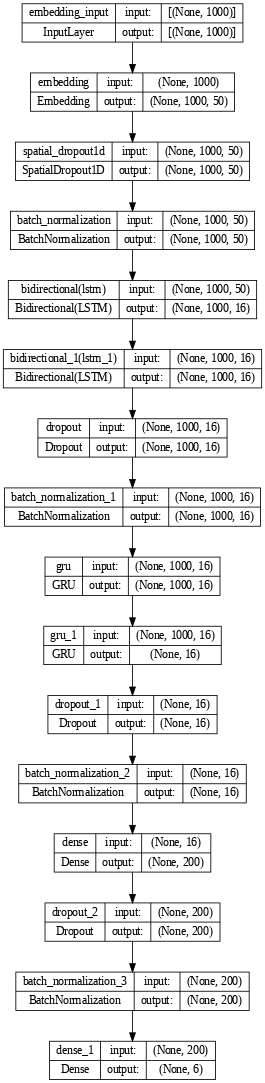

Epoch 1/100
35/35 [==============================] - 26s 420ms/step - loss: 7.2821e-04 - accuracy: 0.9997 - val_loss: 1.8697 - val_accuracy: 0.7585
Epoch 2/100
35/35 [==============================] - 12s 351ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 2.5783 - val_accuracy: 0.6865
Epoch 3/100
35/35 [==============================] - 12s 351ms/step - loss: 9.3887e-04 - accuracy: 0.9999 - val_loss: 2.7399 - val_accuracy: 0.6745
Epoch 4/100
35/35 [==============================] - 12s 343ms/step - loss: 2.2596e-04 - accuracy: 0.9999 - val_loss: 2.2869 - val_accuracy: 0.7166
Epoch 5/100
35/35 [==============================] - 12s 346ms/step - loss: 7.1339e-04 - accuracy: 0.9998 - val_loss: 2.1614 - val_accuracy: 0.7263
Epoch 6/100
35/35 [==============================] - 12s 345ms/step - loss: 1.3957e-04 - accuracy: 1.0000 - val_loss: 2.4542 - val_accuracy: 0.7069
Epoch 7/100
35/35 [==============================] - 12s 332ms/step - loss: 4.0484e-04 - accuracy: 0.9999 - val_loss

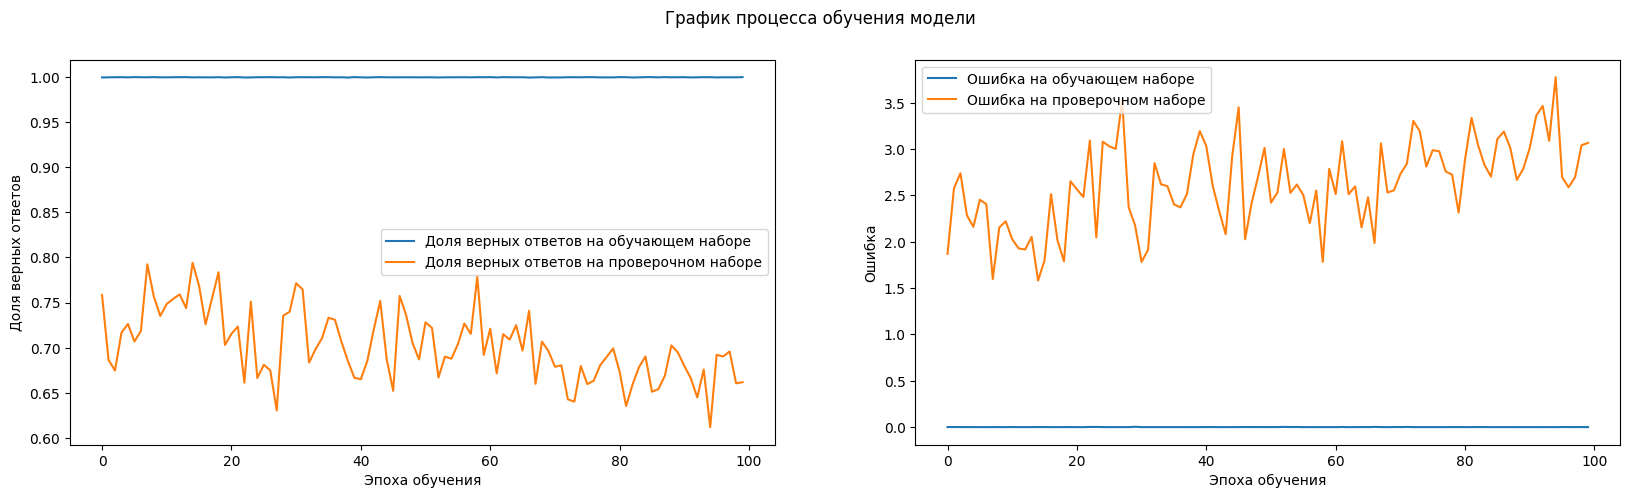

209/209 [==============================] - 15s 64ms/step


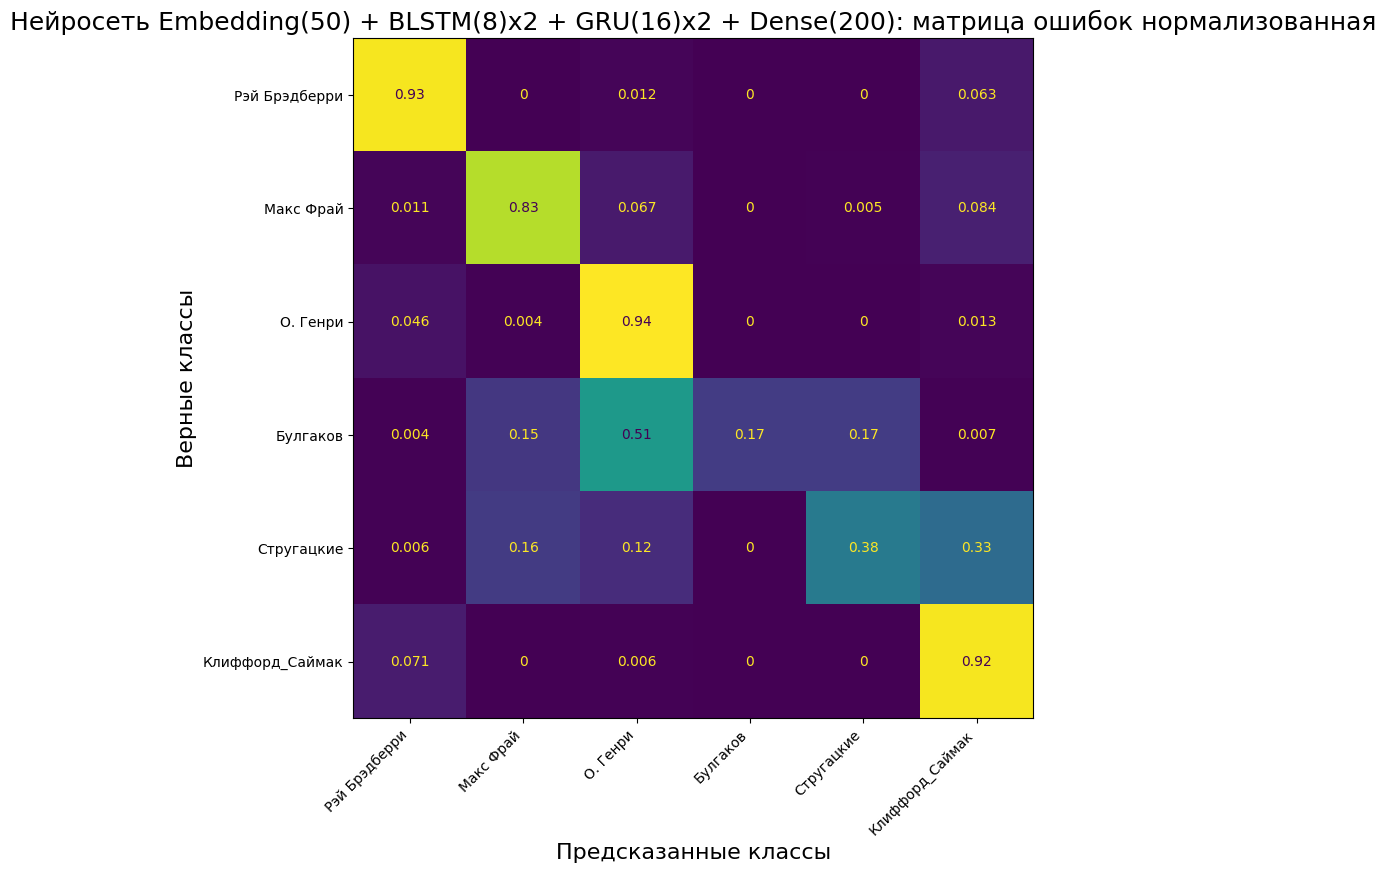

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Рэй Брэдберри         92% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Макс Фрай             83% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              94% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Булгаков              51% сеть отнесла к классу О. Генри             - НЕВЕРНО :-(
Класс: Стругацкие            38% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Клиффорд_Саймак       92% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  69%


In [ ]:
x_train, y_train, x_test, y_test = param(40000, 1000, 100, text_train)

compile_train_eval_model(model_LSTM_6,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

In [ ]:
model_LSTM_6 = Sequential()
model_LSTM_6.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_6.add(SpatialDropout1D(0.4))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_6.add(GRU(16, reset_after=True))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Dense(200, activation='relu'))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
model_LSTM_6.add(Dense(CLASS_COUNT, activation='softmax'))

In [ ]:
VOCAB_SIZE = 20000
WIN_SIZE = 500
WIN_HOP = 50

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 50)           1000000   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 500, 50)          0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_8 (Batc  (None, 500, 50)          200       
 hNormalization)                                                 
                                                                 
 bidirectional_4 (Bidirectio  (None, 500, 16)          3776      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 500, 16)          1600      
 nal)                                                 

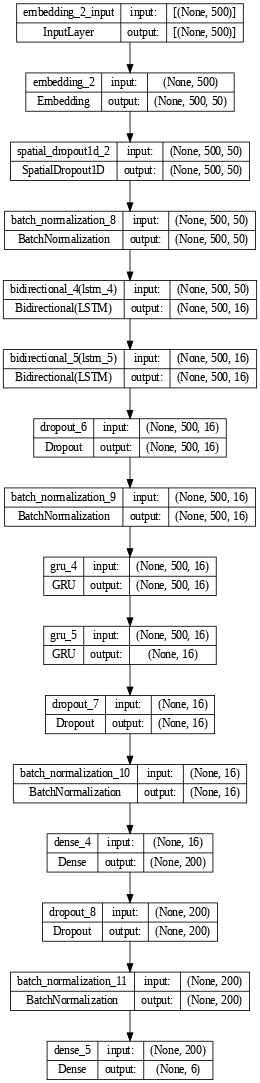

Epoch 1/100
70/70 [==============================] - 33s 288ms/step - loss: 1.9590 - accuracy: 0.2497 - val_loss: 1.7411 - val_accuracy: 0.2923
Epoch 2/100
70/70 [==============================] - 16s 225ms/step - loss: 1.6351 - accuracy: 0.3774 - val_loss: 1.7652 - val_accuracy: 0.2956
Epoch 3/100
70/70 [==============================] - 14s 206ms/step - loss: 1.2083 - accuracy: 0.5380 - val_loss: 2.0131 - val_accuracy: 0.2997
Epoch 4/100
70/70 [==============================] - 14s 199ms/step - loss: 0.8035 - accuracy: 0.6872 - val_loss: 2.1507 - val_accuracy: 0.3375
Epoch 5/100
70/70 [==============================] - 12s 165ms/step - loss: 0.5616 - accuracy: 0.7872 - val_loss: 2.3444 - val_accuracy: 0.4171
Epoch 6/100
70/70 [==============================] - 12s 167ms/step - loss: 0.3168 - accuracy: 0.8949 - val_loss: 2.9980 - val_accuracy: 0.3263
Epoch 7/100
70/70 [==============================] - 11s 164ms/step - loss: 0.1801 - accuracy: 0.9474 - val_loss: 3.1830 - val_accuracy:

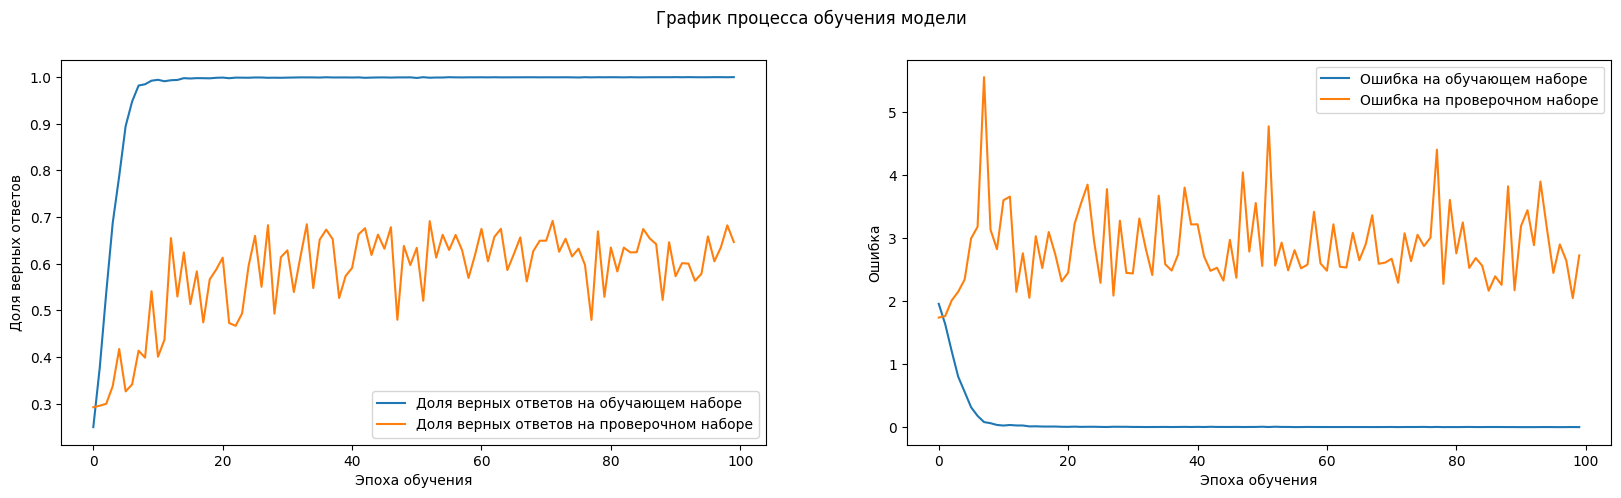

420/420 [==============================] - 17s 36ms/step


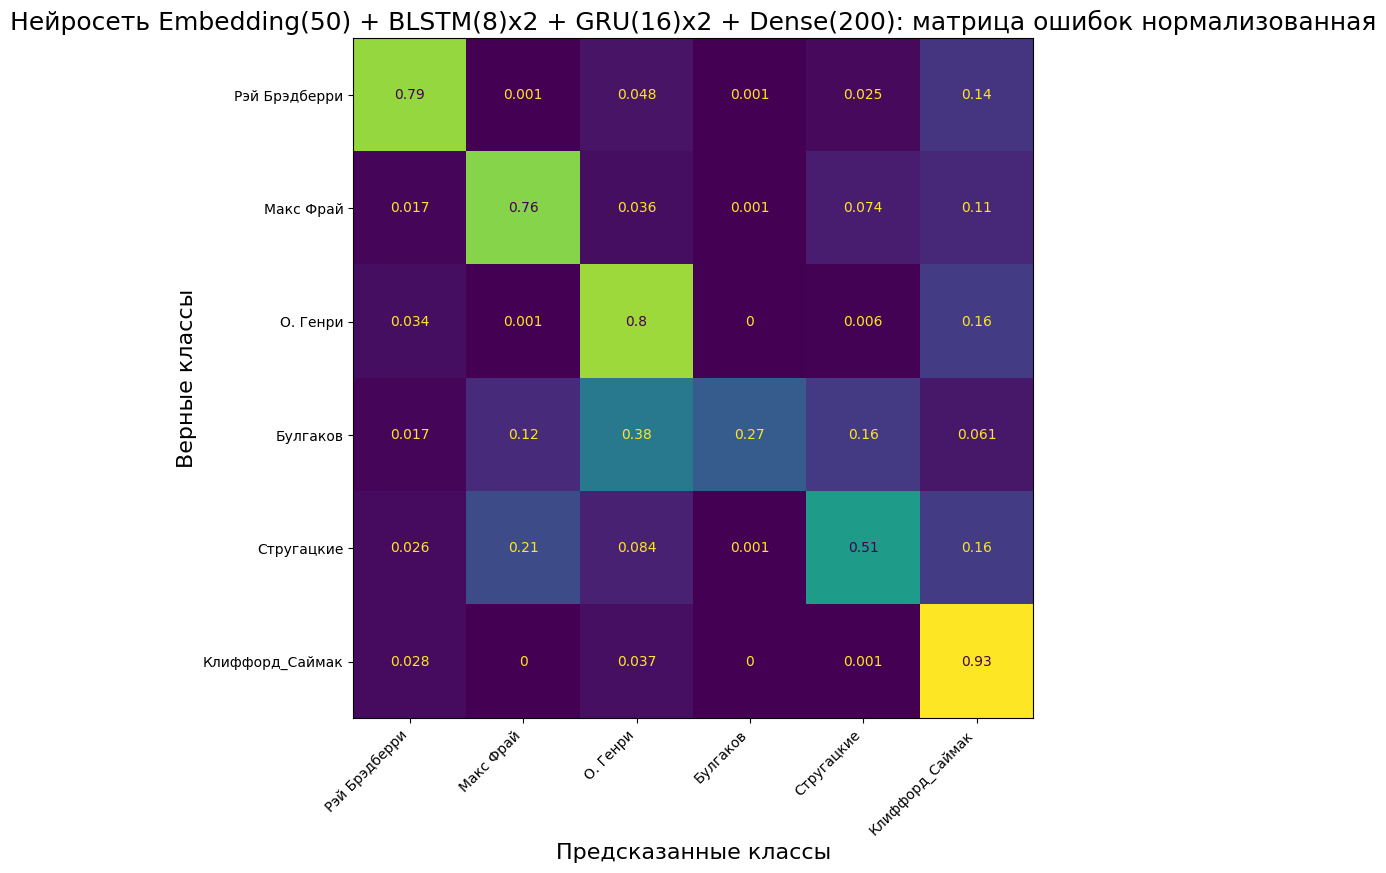

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Рэй Брэдберри         79% сеть отнесла к классу Рэй Брэдберри        - ВЕРНО :-)
Класс: Макс Фрай             76% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              80% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Булгаков              38% сеть отнесла к классу О. Генри             - НЕВЕРНО :-(
Класс: Стругацкие            51% сеть отнесла к классу Стругацкие           - ВЕРНО :-)
Класс: Клиффорд_Саймак       93% сеть отнесла к классу Клиффорд_Саймак      - ВЕРНО :-)

Средняя точность распознавания:  68%


In [ ]:
x_train, y_train, x_test, y_test = param(VOCAB_SIZE, WIN_SIZE, WIN_HOP, text_train)

compile_train_eval_model(model_LSTM_6,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')

In [ ]:
VOCAB_SIZE = 20000
WIN_SIZE = 2000
WIN_HOP = 200

In [ ]:
model_LSTM_6 = Sequential()
model_LSTM_6.add(Embedding(VOCAB_SIZE, 50, input_length=WIN_SIZE))
model_LSTM_6.add(SpatialDropout1D(0.4))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True)))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True))
model_LSTM_6.add(GRU(16, reset_after=True))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())

model_LSTM_6.add(Dense(200, activation='relu'))
model_LSTM_6.add(Dropout(0.3))
model_LSTM_6.add(BatchNormalization())
model_LSTM_6.add(Dense(CLASS_COUNT, activation='softmax'))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2000, 50)          1000000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 2000, 50)         0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_12 (Bat  (None, 2000, 50)         200       
 chNormalization)                                                
                                                                 
 bidirectional_6 (Bidirectio  (None, 2000, 16)         3776      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 2000, 16)         1600      
 nal)                                                 

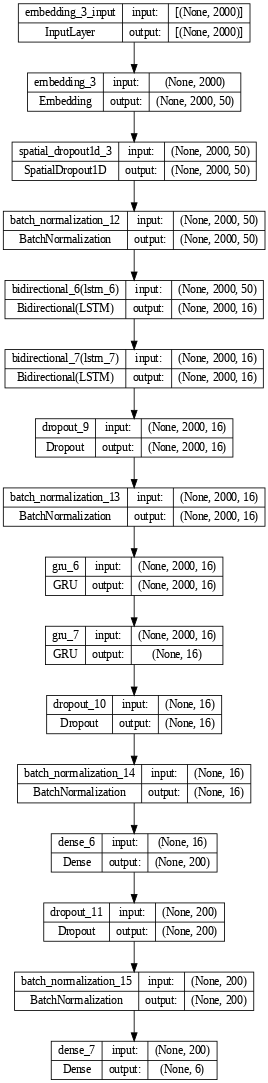

Epoch 1/100
18/18 [==============================] - 28s 615ms/step - loss: 0.0421 - accuracy: 0.9926 - val_loss: 4.8022 - val_accuracy: 0.4366
Epoch 2/100
18/18 [==============================] - 9s 485ms/step - loss: 0.0120 - accuracy: 0.9970 - val_loss: 4.5113 - val_accuracy: 0.4590
Epoch 3/100
18/18 [==============================] - 8s 477ms/step - loss: 0.0083 - accuracy: 0.9983 - val_loss: 3.9710 - val_accuracy: 0.4985
Epoch 4/100
18/18 [==============================] - 9s 484ms/step - loss: 0.0110 - accuracy: 0.9978 - val_loss: 4.4316 - val_accuracy: 0.4635
Epoch 5/100
18/18 [==============================] - 8s 447ms/step - loss: 0.0094 - accuracy: 0.9975 - val_loss: 4.7105 - val_accuracy: 0.4747
Epoch 6/100
18/18 [==============================] - 9s 483ms/step - loss: 0.0312 - accuracy: 0.9929 - val_loss: 4.0123 - val_accuracy: 0.4747
Epoch 7/100
18/18 [==============================] - 9s 526ms/step - loss: 0.0173 - accuracy: 0.9960 - val_loss: 3.8973 - val_accuracy: 0.495

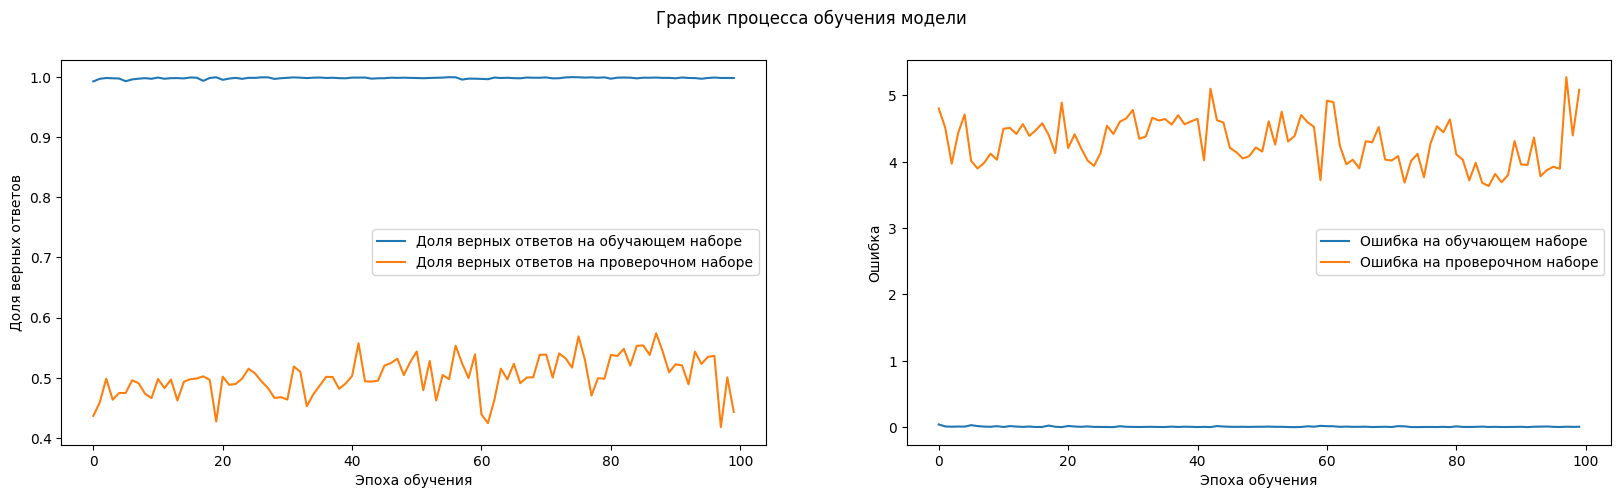

104/104 [==============================] - 14s 115ms/step


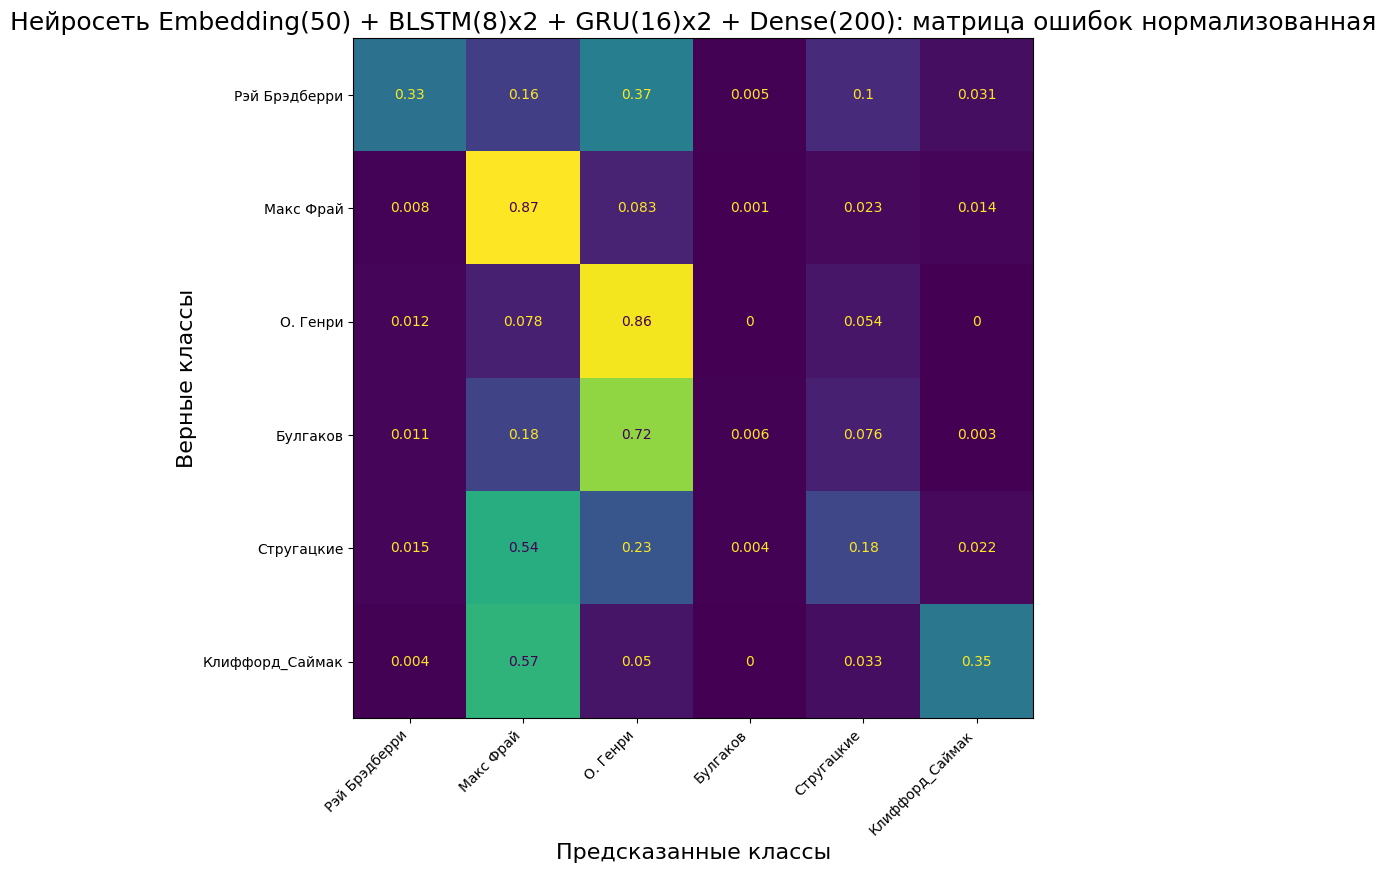

----------------------------------------------------------------------------------------------------
Нейросеть: Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)
Класс: Рэй Брэдберри         37% сеть отнесла к классу О. Генри             - НЕВЕРНО :-(
Класс: Макс Фрай             87% сеть отнесла к классу Макс Фрай            - ВЕРНО :-)
Класс: О. Генри              86% сеть отнесла к классу О. Генри             - ВЕРНО :-)
Класс: Булгаков              72% сеть отнесла к классу О. Генри             - НЕВЕРНО :-(
Класс: Стругацкие            54% сеть отнесла к классу Макс Фрай            - НЕВЕРНО :-(
Класс: Клиффорд_Саймак       57% сеть отнесла к классу Макс Фрай            - НЕВЕРНО :-(

Средняя точность распознавания:  43%


In [ ]:
x_train, y_train, x_test, y_test = param(VOCAB_SIZE, WIN_SIZE, WIN_HOP, text_train)

compile_train_eval_model(model_LSTM_6,
                         x_train, y_train,
                         x_test, y_test,
                         optimizer='rmsprop',
                         epochs=100,
                         batch_size=512,
                         class_labels=CLASS_LIST,
                         title='Embedding(50) + BLSTM(8)x2 + GRU(16)x2 + Dense(200)')